In [1]:
import torch
import torch.nn
import numpy as np
import matplotlib.pyplot as plt
import argparse
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import json
import glob
import os
from torch.utils.data import Dataset, DataLoader 
from tqdm.auto import tqdm
from torchvision import transforms, utils
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import segmentation_models_pytorch as smp

In [2]:
import warnings
warnings.filterwarnings('ignore')
# nan을 나눌때 error가 떠서 안보고 싶었음

segmentation은 다음 github를 참고함 
https://github.com/fxia22/pointnet.pytorch

# preprocessing 

`synsetoffset2category.txt`를 읽어서 목록을 생성 
`num_seg_classes.txt`에 정보를 입력 

In [3]:
def get_segmentation_classes(root):
    catfile = os.path.join(root, 'synsetoffset2category.txt')
    cat = {}
    meta = {}

    with open(catfile, 'r') as f:
        for line in f:
            ls = line.strip().split() # 공백 제거 후 split진행
            cat[ls[0]] = ls[1]
    for item in cat: #list(cat.keys())
        dir_seg = os.path.join(root, cat[item], 'points_label') #folder를 가지고 온다.
        dir_point = os.path.join(root, cat[item], 'points')     #read folder
        fns = sorted(os.listdir(dir_point)) # dir_point에 들어있는 list를 모두 조회
        meta[item] = [] 
        for fn in fns:   
            token = (os.path.splitext(os.path.basename(fn))[0])
            meta[item].append((os.path.join(dir_point, token + '.pts'), os.path.join(dir_seg, token + '.seg')))
    with open(os.path.join(os.path.dirname(os.path.realpath(root)), 'num_seg_classes.txt'), 'w') as f:
        for item in cat:
            datapath = []
            num_seg_classes = 0
            for fn in meta[item]:
                datapath.append((item, fn[0], fn[1]))

            for i in tqdm(range(len(datapath))):
                l = len(np.unique(np.loadtxt(datapath[i][-1]).astype(np.uint8)))
                if l > num_seg_classes:
                    num_seg_classes = l
            print("category {} num segmentation classes {}".format(item, num_seg_classes))
            f.write("{}\t{}\n".format(item, num_seg_classes))

In [4]:
# 한번만 만들면 됨 
# root ="./PointNet/
root = os.path.abspath("./")+"/shapenetcore_partanno_segmentation_benchmark_v0/"
# get_segmentation_classes(root)

# Point Augmentation 

In [5]:
class Normalize():
    def __call__(self, pointcloud): 
        assert len(pointcloud.shape)==2 # (point_num, 3)이 아니면 assert 
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) # point를 기준으로(axis=0) normalize진행
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1)) #norm을 구한뒤 나눈 값을 std로 사용하여 
        #normalize를 진행함

        return  norm_pointcloud
    
class RandRotation_z():
    """
    https://en.wikipedia.org/wiki/Rotation_matrix    
    z에 대해서 rotation을 하는 matrix
    """
    def __call__(self, pointcloud):

        assert len(pointcloud.shape)==2

        # theta = random.random() * 2. * math.pi
        theta = np.random.uniform(0,np.pi*2)
        rot_matrix = np.array([[ np.cos(theta), -np.sin(theta),    0],
                               [ np.sin(theta),  np.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud

class RandomNoise():
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape)) # normal distribution을 생성후 
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud
class ToTensor():
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        return torch.tensor(pointcloud,dtype = torch.float32)
        # return torch.from_numpy(pointcloud)


def default_transforms():
    return transforms.Compose([
                                # PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])    

# Define Dataset 
------


In [6]:
class ShapeNetDataset():
    '''
    class_choice = None : all category if you want specific class, 
    set class_choice = ["Chair", "Airplane"]
        
    '''
    def __init__(self,
                 root,
                 npoints=2500,
                 show=False,
                 class_choice=None,
                 split='train',
                transform = default_transforms()):
        self.npoints = npoints
        self.root = root
        self.catfile = os.path.join(self.root, 'synsetoffset2category.txt')
        self.cat = {}
        # self.classification = classification
        self.seg_classes = {}
        self.transform = transform
        with open(self.catfile, 'r') as f: # file open
            for line in f:
                ls = line.strip().split()
                self.cat[ls[0]] = ls[1]
        #print(self.cat)
        if not class_choice is None:
            self.cat = {k: v for k, v in self.cat.items() if k in class_choice}

        self.id2cat = {v: k for k, v in self.cat.items()}

        self.meta = {}
        splitfile = os.path.join(self.root, 'train_test_split', 'shuffled_{}_file_list.json'.format(split))
        #from IPython import embed; embed()
        filelist = json.load(open(splitfile, 'r')) # 파일이 json으로 되어있음 
        for item in self.cat:
            self.meta[item] = []

        for file in filelist:
            _, category, uuid = file.split('/')
            if category in self.cat.values(): #category에 해당하는 것만 가지고 온다. 
                self.meta[self.id2cat[category]].append((os.path.join(self.root, category, 'points', uuid+'.pts'),
                                        os.path.join(self.root, category, 'points_label', uuid+'.seg')))

        self.datapath = []
        for item in self.cat:
            for fn in self.meta[item]:
                self.datapath.append((item, fn[0], fn[1]))

        self.classes = dict(zip(sorted(self.cat), range(len(self.cat))))
        
        with open(os.path.join(os.path.dirname(os.path.realpath(root)), 'num_seg_classes.txt'), 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.seg_classes[ls[0]] = int(ls[1])
        self.num_seg_classes = self.seg_classes[list(self.cat.keys())[0]]
        # if self.classification:
        # else:
        if show:
            print("class: categorical = \n",self.classes)
            print("class: seg_num = \n",self.seg_classes, self.num_seg_classes)

        

    def __getitem__(self, index):
        fn = self.datapath[index]
        classes = self.classes[self.datapath[index][0]]  
        point_set = np.loadtxt(fn[1]).astype(np.float32) #read pts file 
        seg = np.loadtxt(fn[2]).astype(np.int64)         #read seg file
        #print(point_set.shape, seg.shape)
        
        # seg에서 npoint갯수만큼을 random하게 sampling합니다. 
        choice = np.random.choice(len(seg), self.npoints, replace=True) #index를 random sampling
        #resample
        point_set = point_set[choice, :]#좌표는 상관없이 sampling
        seg = seg[choice]
        
        seg = torch.tensor(seg,dtype= torch.int64)
        classes = torch.tensor(classes,dtype= torch.int64)
        # point_set = torch.from_numpy(point_set)
        # seg = torch.from_numpy(seg)
        # cls = torch.from_numpy(np.array([classes]).astype(np.int64))
        # if self.transform is not None:
        #     point_set = 
        if self.transform is not None:
            point_set = self.transform(point_set)
        return {"pointcloud":point_set.T, # (num_sample,channel) => (channel,num_sample)
               "category":classes,
               "seg":seg}
        
        
#         if self.classification:
#             return point_set, classes
#         else:
#             return point_set, seg

    def __len__(self):
        return len(self.datapath)


# Generate Dataset, DataLoader 

In [7]:
train_transform = transforms.Compose([
    Normalize(),
    RandRotation_z(),
    RandomNoise(),
    ToTensor()
])
valid_transform = transforms.Compose([
    Normalize(),
    # RandRotation_z(),
    # RandomNoise(),
    ToTensor()
])
train_dataset  = ShapeNetDataset(root,npoints=2500,show =True,
                 class_choice=["Airplane"],split='train',transform=train_transform)
valid_dataset  = ShapeNetDataset(root,npoints=2500,
                 class_choice=["Airplane"],split='val',transform=valid_transform)
test_dataset   = ShapeNetDataset(root,npoints=2500,
                 class_choice=["Airplane"],split='test',transform=valid_transform)


class: categorical = 
 {'Airplane': 0}
class: seg_num = 
 {'Airplane': 4, 'Bag': 2, 'Cap': 2, 'Car': 4, 'Chair': 4, 'Earphone': 3, 'Guitar': 3, 'Knife': 2, 'Lamp': 4, 'Laptop': 2, 'Motorbike': 6, 'Mug': 2, 'Pistol': 3, 'Rocket': 3, 'Skateboard': 3, 'Table': 3} 4


In [8]:
   
def train_show(point ,label = None):
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,5),subplot_kw={"projection":"3d"})
    x,y,z = point
    if label is  None:
        ax.scatter3D(x,y,z,  s=5, alpha=0.5)
    else:
        ax.scatter3D(x,y,z, c=label,cmap='inferno',s=5,alpha=0.5)
    ax.view_init(elev=30,azim=300)    
    plt.show()

Train dataset size:  1958
Valid dataset size:  1958
Test dataset size:  341
Number of classes:  1
Sample pointcloud shape:  torch.Size([3, 2500])
Class:  Airplane


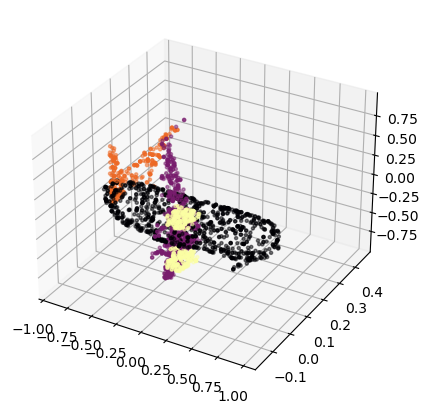

In [9]:
i=50
inv_classes = {i: cat for cat, i in train_dataset.classes.items()}
data = valid_dataset[i]
print('Train dataset size: ', int(train_dataset.__len__()))
print('Valid dataset size: ', int(train_dataset.__len__()))
print('Test dataset size: ', test_dataset.__len__())
print('Number of classes: ', len(train_dataset.classes))
print('Sample pointcloud shape: ', data['pointcloud'].size())
print('Class: ', inv_classes[data['category'].item()])
train_show(data["pointcloud"],data["seg"])

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32,shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32,shuffle=False)


# Network architecture for part segmentation

## 본 Notebook은 Main Paper에서 제시한 Segmentation을 구현하였으나
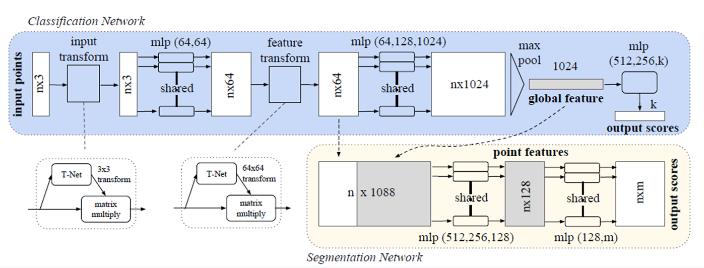
## Supplementary에서는 다음과 같은 구조가 가장 좋은 성능을 내었다고 제시함
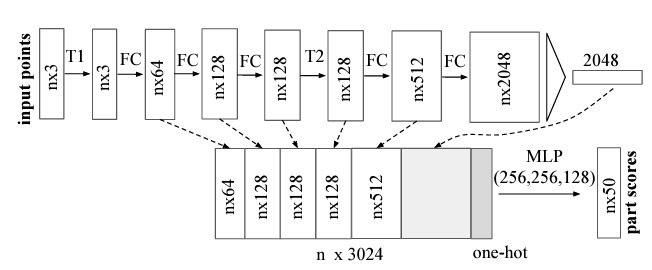

In [11]:
def mlp_block(in_dim, out_dim,act_f = True):
    layers = [nn.Conv1d(in_dim, out_dim, kernel_size=1,stride=1),
        nn.BatchNorm1d(out_dim),
             ]
    if act_f:
        layers+=[nn.ReLU()]
    return nn.Sequential(*layers)

def fc_block(in_dim, out_dim,dropout_rate = None):
    layers = [nn.Linear(in_dim, out_dim,bias=False),]
    if dropout_rate is not None:
        layers+= [nn.Dropout(p=dropout_rate)]
        
    layers += [nn.BatchNorm1d(out_dim),
               nn.ReLU()]
    return nn.Sequential(*layers)


class Tnet(nn.Module):
    def __init__(self,k=3):
        super().__init__()
        """
        k: point feature (x,y,z + alpha)
        Note that 1x1 conv is same fully connected layer
        output must be k x k matrix because Tnet learned transform matrix
        """
        self.k = k
        self.mlp = nn.Sequential(mlp_block(k,64),
                                mlp_block(64,128),
                                mlp_block(128,1024))
        self.fc = nn.Sequential(fc_block(1024,512),
                               fc_block(512,256))
        self.liner = nn.Linear(256,k*k)

        # self.pool = nn.MaxPool1d(1024)
        
        
    def forward(self,x):
        # input.shape = (batch, n, k)
        x = self.mlp(x)
        x = nn.MaxPool1d(x.size(-1))(x)
        # print(x.shape)
        
        x = nn.Flatten(1)(x)
        
        x = self.fc(x)
        #원래의 정보를 더해줌으로서 변형이 심하지 않게 보존 
        identity = torch.eye(self.k, requires_grad=True).repeat(x.size(0),1,1) 
        if x.is_cuda:
            identity = identity.to(device)
        matrix = self.liner(x).view(-1,self.k,self.k) + identity
        return matrix

    
    
class Transform(nn.Module):
    def __init__(self,k=3):
        super().__init__()
        # self.
        self.transform = Tnet(k=k)
                
    def forward(self,x):
        matrix = self.transform(x)
        x = torch.bmm(x.transpose(1,2),matrix).transpose(1,2)
        return x , matrix
    
    
class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        
        self.input_transform   = Transform(k=3)
        self.feature_transform = Transform(k=64)
        self.mlp1 = nn.Sequential(mlp_block(3,64))
        self.mlp2 = nn.Sequential(mlp_block(64,128))
        self.mlp3 = nn.Sequential(mlp_block(128,1024,act_f=False))
        
        self.fc1 = fc_block(1024,512,dropout_rate = None)
        self.fc2 = fc_block(512,256,dropout_rate=0.7) #논문에서 drop out rate을 0.7로 설정함 
        self.fc3 = nn.Linear(256, classes)
        # self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x, matrix3x3 = self.input_transform(x)
        x = self.mlp1(x)
        local_feature ,matrix64x64 = self.feature_transform(x)
        x = self.mlp2(local_feature)
        x = self.mlp3(x)
        global_feature = nn.MaxPool1d(x.size(-1))(x)
        x = nn.Flatten(1)(global_feature)
        
        ## classifier part
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # output = F.log_softmax(x,dim=1)
        output = x
        
        
        return {"output":output,
            "local_feature":local_feature,
            "global_feature":global_feature,
            "matrix3x3":matrix3x3,
            "matrix64x64":matrix64x64}

class SegPointNet(nn.Module):
    def __init__(self, classes = 10 , seg_classes = 50):
        super().__init__()
        self.pointnet = PointNet(classes)
        self.seg_mlp1 = nn.Sequential(mlp_block(1024+64,512))
        self.seg_mlp2 = nn.Sequential(mlp_block(512,256))
        self.seg_mlp3 = nn.Sequential(mlp_block(256,128))
        self.seg_mlp4 = nn.Conv1d(128,seg_classes,1)
    
    def forward(self,x):
        pts = self.pointnet(x)
        local_feature  = pts["local_feature"]
        global_feature = pts["global_feature"]
        concat = torch.cat((local_feature,global_feature.repeat(1,1,local_feature.size(-1))),dim=1)
        x = self.seg_mlp1(concat)
        x = self.seg_mlp2(x)
        x = self.seg_mlp3(x)
        seg_output = self.seg_mlp4(x).transpose(1,2).contiguous()
        #output : batch_size , n_pts ,seg_classes
        return F.log_softmax(seg_output,dim=2) , pts["matrix3x3"],pts["matrix64x64"]

In [12]:
class PointNetLoss(nn.Module):
    def __init__(self,criterion = nn.CrossEntropyLoss()):
        super().__init__()
        self.criterion = criterion
        
    def L2_reg(self,m3x3,m64x64,weight_decay):
        bs      = m3x3.size(0)
        id3x3   = torch.eye(3, requires_grad=True).repeat(bs,1,1)
        id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
        if m3x3.is_cuda:
            id3x3   = id3x3.to(device)
            id64x64 = id64x64.to(device)
        # regularization I - AA.T
        diff3x3   = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2)) 
        diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))   
        
        return weight_decay * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)
    def forward(self,logits, labels, m3x3,m64x64,weight_decay = 1e-4):
        return self.criterion(logits,labels)+self.L2_reg(m3x3,m64x64,weight_decay)

In [13]:
classes = len(train_dataset.classes)
seg_classes = train_dataset.num_seg_classes
print("classes:", classes,"\nseg_classes: ", seg_classes)

classes: 1 
seg_classes:  4


In [14]:
# outputs,m3x3,m64x64 = model(inputs)

# pred = outputs.view(-1, seg_classes)
# target = labels.view(-1, 1)[:, 0] - 1 #-1을 해주는 이유는 label이 1부터 시작하기 때문
# loss = loss_fc(pred,target,m3x3,m64x64)
# pred_choice = pred.data.max(1)[1]
# acc = torch.mean(pred_choice.eq(target).float())
# print(loss, acc)

# Set GPU

In [15]:
# # Set device
# os.environ["CUDA_VISIBLE_DEVICES"] ='1' # set gpu numver 
# device = torch.device("cuda:1" if torch.cuda.is_available() else 'cpu')
# print(device)

------
miou는 다음을 참조 https://gaussian37.github.io/vision-segmentation-miou/

In [16]:
def miou(pred ,target):
    iou = []
    pred = pred.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    cm =confusion_matrix(pred,target)
    cm = (cm/cm.sum(axis=1).reshape(-1,1)).round(2)
    cm[np.isnan(cm)]=0
    return np.round(np.mean(np.diag(cm)),4) #대각을 가지고 MIOU를 계산 
def train_show2(iteration, point,predict,label = None):
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(7,3),subplot_kw={"projection":"3d"})
    x,y,z = point
    iou_score = miou(predict, label)
    # score = torch.mean((predict==label).float()).item()
    plt.suptitle(f"{iteration} result , mIoU : {iou_score}",position = (0.5, 1+0.05))
    ax[0].scatter3D(x,y,z, c=label,cmap='inferno',s=5,alpha=0.5)
    ax[0].set_title("labels")
    ax[1].scatter3D(x,y,z, c=predict,cmap='inferno',s=5,alpha=0.5)
    ax[1].set_title("predict")
    ax[0].view_init(elev=30,azim=300)    
    ax[1].view_init(elev=30,azim=300)   
    plt.savefig(f"./part_segmentation_result/{iteration}.png",dpi=200)
    plt.show()

In [17]:
# device    = 'cuda:0'
device = 'cpu'
model     = SegPointNet(classes,seg_classes)
model.to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fc   = PointNetLoss(criterion=nn.NLLLoss())
n_epochs = 3

In [18]:
data = next(iter(valid_loader))
show_inputs , show_labels = data['pointcloud'].to(device).float(),data['seg'].to(device)
show_inputs.shape, show_labels.shape
# show_data.shape , category , show_seg.shape

(torch.Size([32, 3, 2500]), torch.Size([32, 2500]))

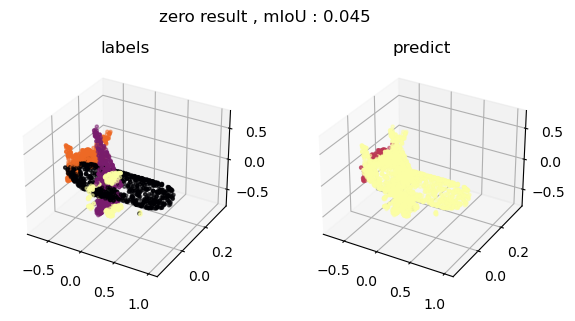

In [19]:
show_index = 10
show_output , m3x3,m64x64 = model(show_inputs)
train_show2("zero",show_inputs[show_index].detach().cpu(),
    show_output.max(2)[1][show_index].detach().cpu()+1,
    show_labels[show_index].detach().cpu()
           )

In [20]:
# for i,data in tqdm(enumerate(testdataloader, 0)):
#     points, target = data
#     points = points.transpose(2, 1)
#     points, target = points.cuda(), target.cuda()
#     classifier = classifier.eval()
#     pred, _, _ = classifier(points)
#     pred_choice = pred.data.max(2)[1]

#     pred_np = pred_choice.cpu().data.numpy()
#     target_np = target.cpu().data.numpy() - 1

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

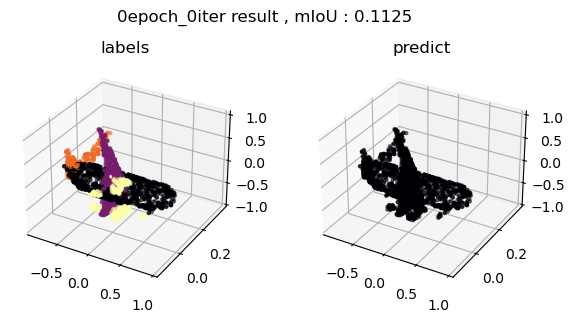

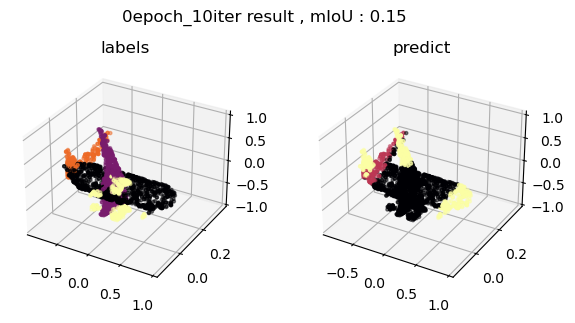

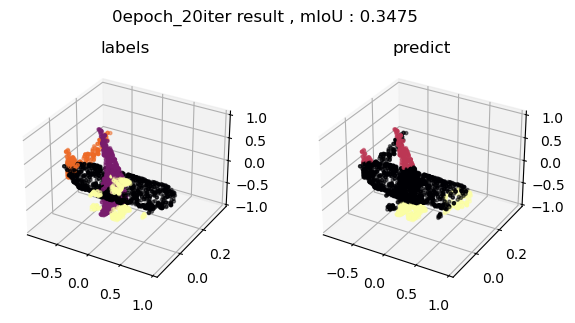

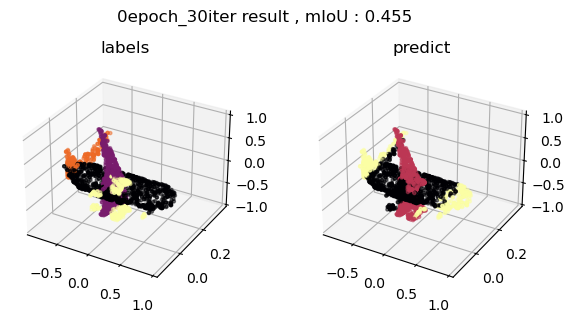

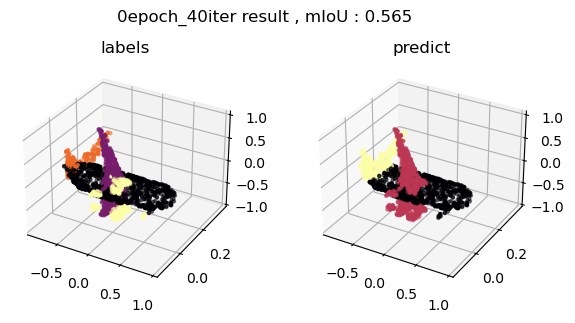

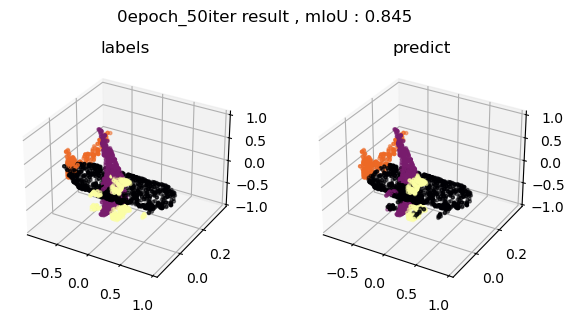

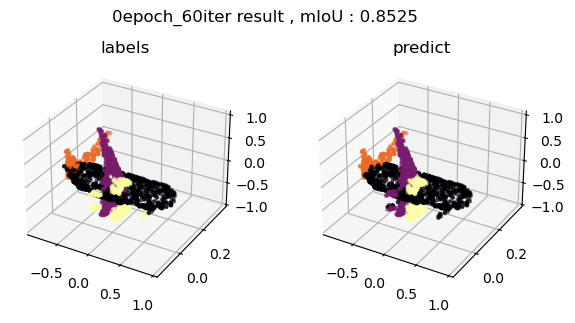

  0%|          | 0/13 [00:00<?, ?it/s]

Loss is decreased


  0%|          | 0/62 [00:00<?, ?it/s]

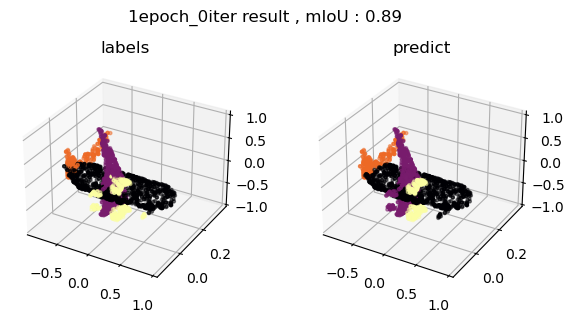

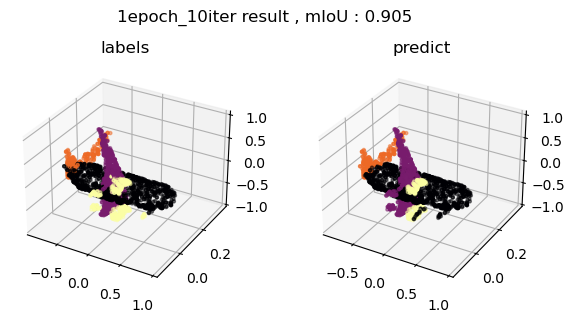

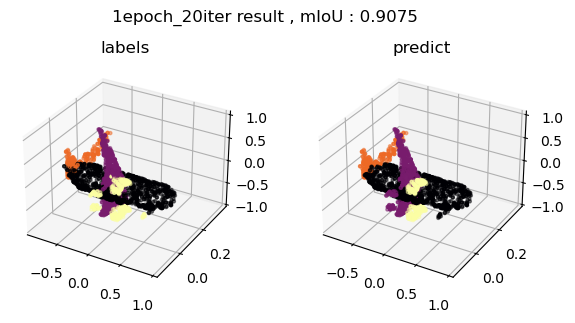

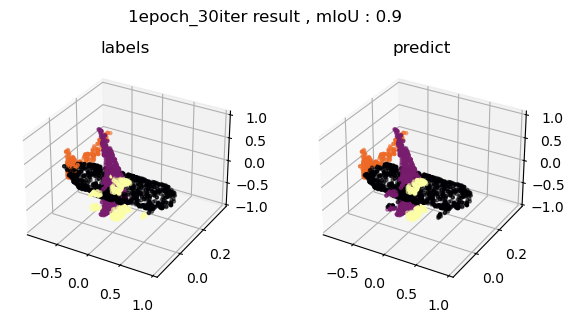

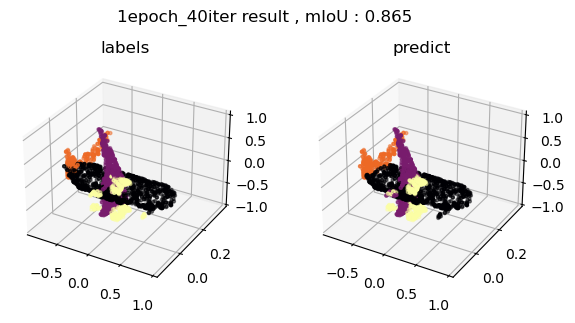

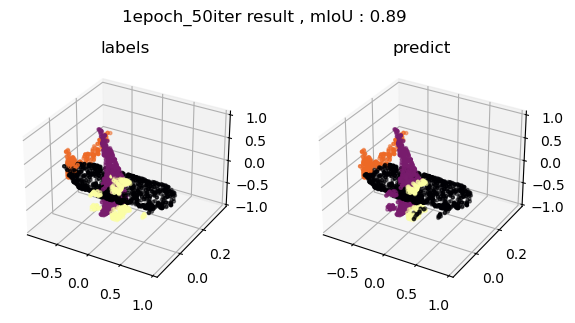

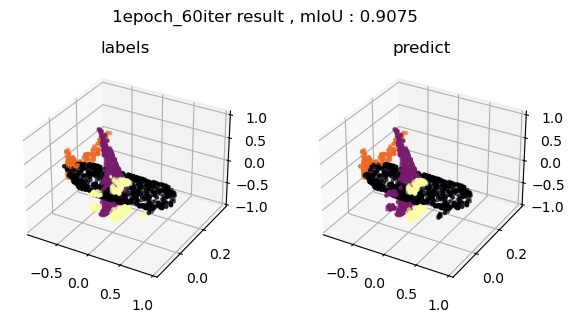

  0%|          | 0/13 [00:00<?, ?it/s]

Loss is decreased


  0%|          | 0/62 [00:00<?, ?it/s]

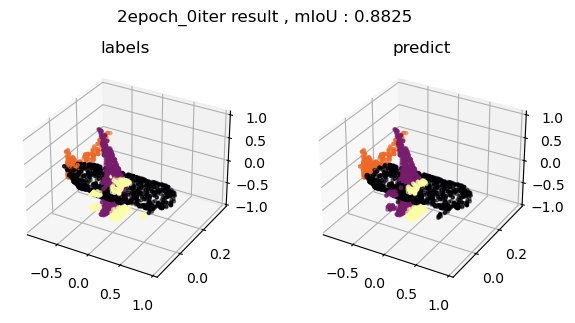

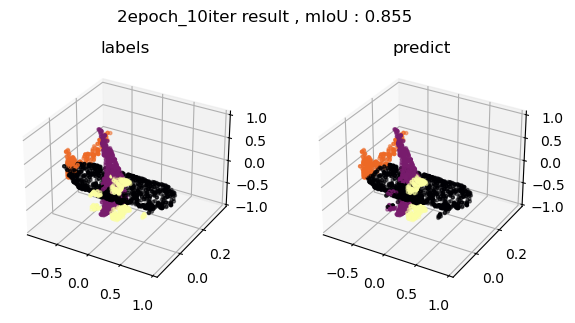

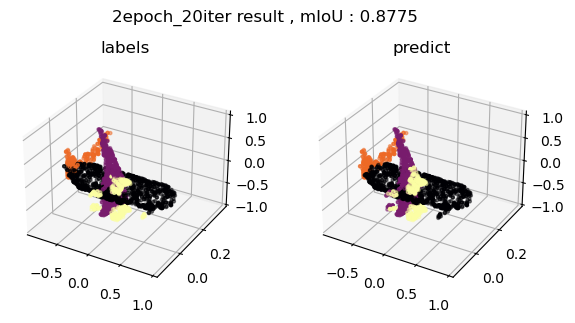

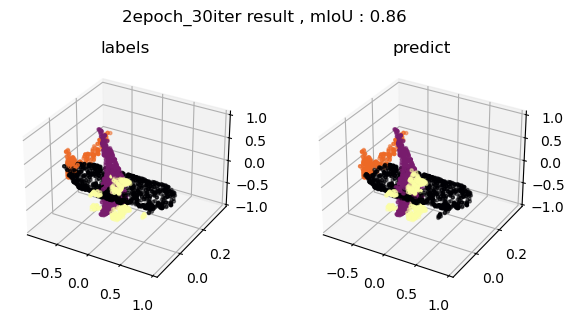

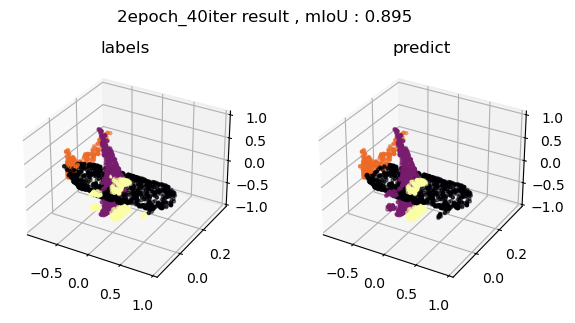

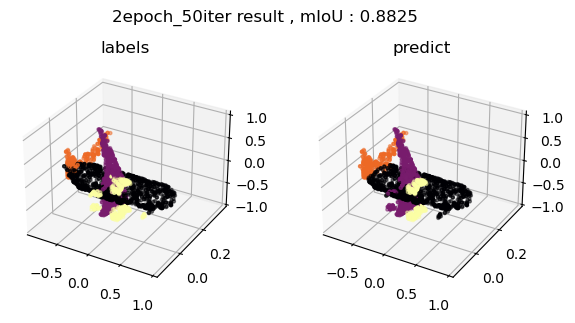

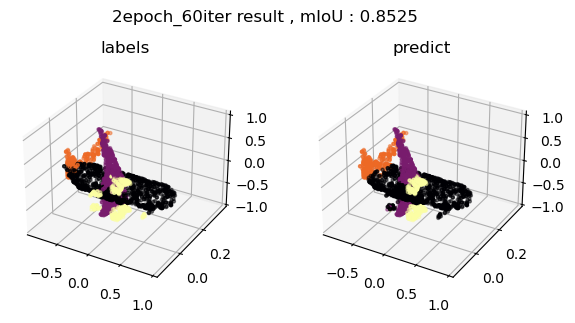

  0%|          | 0/13 [00:00<?, ?it/s]

In [21]:
show_index = 11
valid_min = np.inf
TRAIN_LOSS = []
VALID_LOSS = []
TRAIN_ACC  = []
VALID_ACC  = []

for epoch in tqdm(range(n_epochs)):
    tloss = []
    tacc  = []
    model.train()
    bar = tqdm(train_loader)
    for i , data in enumerate(bar,0):
        inputs,labels = data['pointcloud'].to(device).float(),data['seg'].to(device)
        optimizer.zero_grad()
        output, m3x3, m64x64 = model(inputs)
        pred = output.view(-1, seg_classes)
        target = labels.view(-1, 1)[:, 0] - 1 #-1을 해주는 이유는 label이 1부터 시작하기 때문
        loss = loss_fc(pred, target, m3x3, m64x64)
        pred_choice = pred.data.max(1)[1]
        # acc = torch.mean(pred_choice.eq(target).float())  
        acc = miou(pred_choice,target)
        loss.backward()
        optimizer.step()
        tloss.append(loss.item())
        tacc.append(acc.item())
        bar.set_description('Train Loss: {:.5f} Train Miou : {:.6f}'.format(
                np.mean(tloss),np.mean(tacc)))
        
        #### show
        if i%10==0:
            model.eval()
            show_output , m3x3,m64x64 = model(show_inputs)
            show_pred = show_output.max(2)[1].detach().cpu()+1
            train_show2(f"{epoch}epoch_{i}iter",
                show_inputs[show_index].detach().cpu(),
                show_pred[show_index],
                show_labels[show_index].detach().cpu()
                       )
            model.train()
        
        
    TRAIN_LOSS.append(np.mean(tloss))
    TRAIN_ACC.append(np.mean(tacc))
    
    model.eval()     
    vloss = []
    vacc = []
    bar = tqdm(valid_loader)
    with torch.no_grad():
        for data in bar:
            inputs,labels = data['pointcloud'].to(device).float(),data['seg'].to(device)
            output, m3x3, m64x64 = model(inputs)
            pred = output.view(-1, seg_classes)
            target = labels.view(-1, 1)[:, 0] - 1 #-1을 해주는 이유는 label이 1부터 시작하기 때문
            loss = loss_fc(pred, target, m3x3, m64x64)
            pred_choice = pred.data.max(1)[1]
            # acc = torch.mean(pred_choice.eq(target).float())  
            acc = miou(pred_choice,target)
            
            vloss.append(loss.item())
            vacc.append(acc.item())
            bar.set_description('Valid Loss: {:.5f} Valid Acc : {:.6f}'.format(
                np.mean(vloss),np.mean(vacc)))
    VALID_LOSS.append(np.mean(vloss))
    VALID_ACC.append(np.mean(vacc))

    
    if valid_min >= VALID_LOSS[-1]:
        valid_min = VALID_LOSS[-1]
        print("Loss is decreased")
        torch.save(model.state_dict(),"./point_seg.pth")
    

In [22]:
# def train_show2(iteration, point,predict,label = None):
#     fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(7,3),subplot_kw={"projection":"3d"})
#     x,y,z = point
#     iou_score = miou(predict, label)
#     # score = torch.mean((predict==label).float()).item()
#     plt.suptitle(f"{iteration} result , iou_score : {iou_score}",position = (0.5, 1+0.05))
#     ax[0].scatter3D(x,y,z, c=label,cmap='inferno',s=5,alpha=0.5)
#     ax[0].set_title("labels")
#     ax[1].scatter3D(x,y,z, c=predict,cmap='inferno',s=5,alpha=0.5)
#     ax[1].set_title("predict")
#     ax[0].view_init(elev=30,azim=300)    
#     ax[1].view_init(elev=30,azim=300)   
#     plt.savefig(f"./part_segmentation_result/{iteration}.png",dpi=200)
#     plt.show()

In [23]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
        layout=go.Layout(
            updatemenus=[dict(type='buttons',
                showactive=False,
                y=1,
                x=0.8,
                xanchor='left',
                yanchor='bottom',
                pad=dict(t=45, r=10),
                buttons=[dict(label='Play',
                    method='animate',
                    args=[None, dict(frame=dict(duration=50, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode='immediate'
                        )]
                    )
                ])]
        ),
        frames=frames
    )

    return fig
def pcshow(xs,ys,zs,label):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color=label),
                                 ),
                      selector=dict(mode='markers'))
    fig.show()
# def label_preproc(path):
#     with open(path,"r") as f:
#         label = read_seg(f.read())
#     return label

# def read_seg(data):
#     conv = {
#     0: lambda x: float(x),  # conversion fn for column 0
#     }
#     seg = np.loadtxt(data.split("\n"), delimiter=" ", converters=conv)
#     return seg
        
        
# def preproc(path):
#     with open(path,'r') as f:
#         pointcloud = read_pts(f.read())
#     return pointcloud
# def read_pts(data):
#     conv = {
#     0: lambda x: float(x),  # conversion fn for column 0
#     1: lambda x: float(x),  # conversion fn for column 1
#     2: lambda x: float(x),  # conversion fn for column 1
#     }
#     pointcloud = np.loadtxt(data.split("\n"), delimiter=" ", converters=conv)
#     return pointcloud

# def pcshow_2(point_set,plot_num,title=None):
#     if title==None:
#         title = [str(i) for i in range(plot_num)]
#     plot_type = {'type': 'surface'}
#     fig = make_subplots(rows=1, cols=plot_num,column_titles=title, specs=[[{'type': 'surface'}for i in range(plot_num)]])
#     for i in range(plot_num):
#         x,y,z = point_set[i].T
        
#         fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
#                                        mode='markers',
#                                    marker=dict(size=2,
#                           line=dict(width=2,
#                           color='DarkSlateGrey'))
#                                    ,name=title[i]),row=1,col=i+1)
#     fig.show()

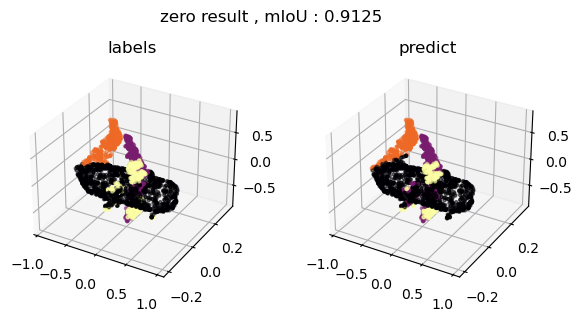

In [24]:
data = next(iter(test_loader))
show_inputs , show_labels = data['pointcloud'].to(device).float(),data['seg'].to(device)

# show_data.shape , category , show_seg.shape
show_index = 10
show_output , m3x3,m64x64 = model(show_inputs)
train_show2("zero",show_inputs[show_index].detach().cpu(),
    show_output.max(2)[1][show_index].detach().cpu()+1,
    show_labels[show_index].detach().cpu()
           )


In [28]:
output, _, _ = model(show_inputs)
pred = output[0].max(1)[1]
target = show_labels[0]-1
print("miou: ",miou(pred,target))

miou:  0.8075


## Label

In [35]:
pcshow(*show_inputs[0].cpu().numpy(),target)

## pred

In [36]:
pcshow(*show_inputs[0].cpu().numpy(),pred)

# 문제점
> 각각의 class에 대해선 segmentation이 가능 
그러나 전체 class에 대해선 어떻게 해야할 지 잘 모르겠음. 
예를 들어 Airplane에는 {0,1,2,3}의 segmentation label이 존재하는데, 
Guitar에도 마찬가지로 {0,1,2,3}의 segmentation label이 존재함. 
DataLoader에서 읽을 때, label을 다시 categorycal하게 해야해서 task가 오래 걸릴 것 같다.
